# Cvičení 9

V dnešním cvičení se budeme zabývat:
* **evaluací modelů**,
* **křížovou validací**,
* **výběrem příznaků**.



In [16]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

random_seed = 42

## Dataset 💲
Využijeme dataset **adult census income** z [Kaggle](https://www.kaggle.com/uciml/adult-census-income).
Cílem úlohy je na základě demografických údajů predikovat, zda příjem člověka přesáhne $50 000 ročně.

Protože, jsme s tímto datasetem již pracovali, pro urychlení přebereme základní předzpracování ze druhého cvičení.

In [17]:
def get_adult_census(one_hot = True, fill_na = True):
    df = pd.read_csv('adult-census.csv')
    df = df.replace('?', np.nan)
    df.drop(columns = ["education"], inplace = True)
    income_category = pd.api.types.CategoricalDtype(categories=['<=50K', '>50K'], ordered=True)
    df['income'] = df['income'].astype(income_category)
    sex_category = pd.api.types.CategoricalDtype(categories=['Female', 'Male'])
    df['sex'] = df['sex'].astype(sex_category)
    
    string_cols = ['native.country', 'occupation', 'workclass', 'marital.status', 'relationship', 'race']
    df[string_cols] = df[string_cols].astype('category')
    
    for col in df.select_dtypes('category').columns:
        df[col] = df[col].cat.codes

    # ONE-HOT encoding
    if one_hot:
        df = pd.get_dummies(df)
    # Missing values
    if fill_na:
        df = df.fillna('-1')
    return df

# načteme si dataset
df = get_adult_census()

# Split the training dataset into 80% train and 20% test
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop(columns=['income']), df.income, test_size=0.2, random_state=random_seed)


print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (26048, 13), y: (26048,)
Test rozměry, X: (6513, 13), y: (6513,)


# Evaluace modelů

Zaměříme se na evaluaci klasifikace.
Nejprve si natrénujme modely rozhodovacího stromu a logistické regrese a podívejme se různými kritérii na jejich výkonnost. 

In [18]:
from sklearn.tree import DecisionTreeClassifier
clfDT = DecisionTreeClassifier(max_depth = 5, random_state = 42)
clfDT.fit(Xtrain, ytrain)
print("Rozhodovací strom")
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clfDT.predict(Xtrain))))
print('Accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, clfDT.predict(Xtest))))

from sklearn.linear_model import LogisticRegression
clfLR = LogisticRegression(max_iter = 1000)
clfLR.fit(Xtrain, ytrain)
print("\nLogistická regrese")
print('Accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clfLR.predict(Xtrain))))
print('Accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, clfLR.predict(Xtest))))

Rozhodovací strom
Accuracy score (train): 0.853732
Accuracy score (test): 0.854598

Logistická regrese
Accuracy score (train): 0.787469
Accuracy score (test): 0.788423


## Matice záměn
Ve `sklearn` je implememntovaná ve `sklearn.metrics.confusion_matrix`.

Dejte si pozor, že $i,j$ tá složka matice záměn $C_{i,j}$ odpovídá počtu bodů z třídy $i$, pro které model predikoval třídu $j$.

Spočítáme testovací matici zmáněn pro oba modely.

In [19]:
cfDT = metrics.confusion_matrix(ytest, clfDT.predict(Xtest))

print("Rozhodovací strom")
print(cfDT)

cfLR = metrics.confusion_matrix(ytest, clfLR.predict(Xtest))
print("\nLogistická regrese")
print(cfLR)

Rozhodovací strom
[[4752  224]
 [ 723  814]]

Logistická regrese
[[4708  268]
 [1110  427]]


Vidíme, že například pro rozhodovací strom tedy máme:
* $\text{TP} = C_{1,1} = 814$, 
* $\text{FP} = C_{0,1} = 224$,
* $\text{FN} = C_{1,0} = 723$,
* $\text{TN} = C_{0,0} = 4752$.

### Úkol - spočtěte další odvozené míry z matice záměn

Konrétně spočtěte TPR, FPR, FNR a TNR (můžete použít `confusion_matrix` s vhodnými parametry).
Dále určte recall a precision.

Potom ručně spočtěte accuracy a F1 score.

Porovnejte ruční výpočet s hodnotami ze `sklearn.metrics.accuracy_score` a `sklearn.metrics.f1_score`.

Porovnejte oba modely.

In [20]:
# Váš kód zde

def print_metrics(cf, ytest, ypred):
    cf_r = np.dot(np.diag(1./cf.sum(axis = 1)), cf)
    # print(cf_r)
    cf_r = metrics.confusion_matrix(ytest, ypred, normalize = 'true')
    print(cf_r)

    print(f"\nTPR = {cf_r[1,1]:.4f}\nFPR = {cf_r[0,1]:.4f}\nFNR = {cf_r[1,0]:.4f}\nTNR = {cf_r[0,0]:.4f}")
    cf_rp = metrics.confusion_matrix(ytest, ypred, normalize = 'pred')
    print(f"\nrecall = TPR = {cf_r[1,1]:.4f}, precision = {cf_rp[1,1]:.4f}")

    acc = (cf[0,0] + cf[1,1])/cf.sum()
    print(f"\naccuracy = {acc:.4f}")
    f1 = 2/(1/cf_r[1,1] + 1/cf_rp[1,1])
    print(f"f1 = {f1:.4f}")
    
    print(f'Accuracy score (test): {metrics.accuracy_score(ytest, ypred):.4f}')
    print(f'F1 score (test): {metrics.f1_score(ytest, ypred):.4f}')
    
print("==========================")
print("Rozhodovací strom")
print_metrics(cfDT, ytest, clfDT.predict(Xtest))

print("==========================")
print("Logistická regrese")
print_metrics(cfLR, ytest, clfLR.predict(Xtest))

Rozhodovací strom
[[0.95498392 0.04501608]
 [0.47039688 0.52960312]]

TPR = 0.5296
FPR = 0.0450
FNR = 0.4704
TNR = 0.9550

recall = TPR = 0.5296, precision = 0.7842

accuracy = 0.8546
f1 = 0.6322
Accuracy score (test): 0.8546
F1 score (test): 0.6322
Logistická regrese
[[0.94614148 0.05385852]
 [0.72218608 0.27781392]]

TPR = 0.2778
FPR = 0.0539
FNR = 0.7222
TNR = 0.9461

recall = TPR = 0.2778, precision = 0.6144

accuracy = 0.7884
f1 = 0.3826
Accuracy score (test): 0.7884
F1 score (test): 0.3826


## ROC křivka a AUC
Pro model logistické regrese si zkusíme vykreslit ROC křivku a spočítat plochu pod touto křivkou (AUC).

Připomeňme, že ROC křivka pro model, který v libovolném bodě $\boldsymbol x$ odhaduje pravděpodobnost $P(Y = 1 | \boldsymbol x)$ příslušnosti ke třídě 1
a jehož finální predikce vznikne jako
$$
 \hat Y = \begin{cases}1 & \text{když } P(Y = 1 | \boldsymbol x) > \tau\\0 & \text{jinak}\end{cases},
$$
je křivka závislosti TPR a FPR na $\tau \in [0,1]$.

Nejprve křivku zkusíme sestrojit ručně. Pro výpočet plochy pod křivkou použijeme `sklearn.metrics.auc`.

Připravme si na začátku predikované pravděpodobnosti třídy $1$.

In [21]:
y_pred_proba = clfLR.predict_proba(Xtest)
p1_hat = y_pred_proba[:,1]
print(p1_hat)

[0.13446092 0.067095   0.14403783 ... 0.25763843 0.12652305 0.23707363]


### Úkol - zkonstruujte a vykreslete ROC křivku

Hýbejte postupně thresholdem od $1$ do $0$ a zaznamenávejte si TPR a FPR.

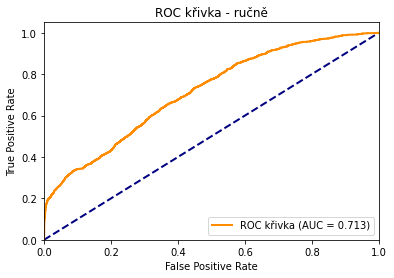

In [22]:
# Váš kód zde

# thresholdy
thresholds = list(reversed(sorted(list({0,1}.union(set(p1_hat))))))

# predikce v rámci tříd
p1_hat_1 = p1_hat[ytest > 0]
p1_hat_0 = p1_hat[ytest < 1]

tpr = []
fpr = []
for thr in thresholds:
    tpr.append((p1_hat_1 > thr).mean())
    fpr.append((p1_hat_0 > thr).mean())
    
# plochu spočteme pomocí funkce    
AUC = metrics.auc(fpr, tpr)

# vykreslení
plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka - ručně")
plt.legend(loc="lower right")
plt.show()

### ROC křivka se sklearn
Nyní zkusíme to samé pomocí `sklearn.metrics.roc_curve` a `sklearn.metrics.roc_auc_score`.

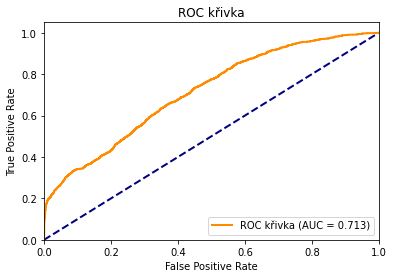

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(ytest, p1_hat)

# AUC = metrics.auc(fpr, tpr)
AUC = metrics.roc_auc_score(ytest, y_pred_proba[:,1])

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

### Úkol - proveďte to samé, pro model rozhodovacího stromu

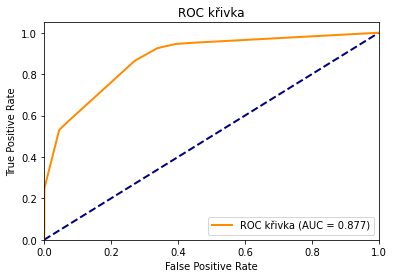

In [24]:
# Váš kód zde
y_pred_proba = clfDT.predict_proba(Xtest)
fpr, tpr, thresholds = metrics.roc_curve(ytest, y_pred_proba[:,1])

AUC = metrics.auc(fpr, tpr)

plt.figure()
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {AUC:.3f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC křivka")
plt.legend(loc="lower right")
plt.show()

Ze všech porovnání nám vychází, že model rozhodovacího stromu je v tomto případě lepší.

# Křížová validace

<center><img src="img/cross_val_split_a.png" width="40%"></center>

Pomocí křížové validace zkusíme najít nejlepší hyperparametry rozhodovacího stromu a KNN.
Nejlepší model potom znovu natrénujeme a otestujeme jeho přesnost na testovací množině.

Nejprve pro hyperparametry rozhodovacího stromu použijeme `sklearn.model_selection.KFold`, který nám umožní vše mít pod kontrolou. Vyzkoušejme si to nejprve pro jednu sadu hyperparametrů.

In [25]:
from sklearn.model_selection import KFold
# ohodnocení pro jednu sadu hyperparametrů už natrénovaného modelu

num_folds = 5
kf = KFold(n_splits = num_folds)
fold_acc = []
for i, (train_index, val_index) in enumerate(kf.split(Xtrain)):
    tX_train, tX_val = Xtrain.iloc[train_index,:], Xtrain.iloc[val_index,:]
    ty_train, ty_val = ytrain.iloc[train_index], ytrain.iloc[val_index]
    print(f"Trénovací množina: {tX_train.shape}, validační množina: {tX_val.shape}")

    clf = DecisionTreeClassifier(max_depth = 5, random_state = 42)
    clf.fit(tX_train, ty_train)
    one_fold_acc = metrics.accuracy_score(ty_val, clf.predict(tX_val))
    print(f"Přesnost na foldu {i + 1} z {num_folds}: {one_fold_acc:.4f}\n")
    fold_acc.append(one_fold_acc)

mean_cv_acc = np.mean(fold_acc)
print(f"Průměrná přesnost: {mean_cv_acc:.4f}")

Trénovací množina: (20838, 13), validační množina: (5210, 13)
Přesnost na foldu 1 z 5: 0.8511

Trénovací množina: (20838, 13), validační množina: (5210, 13)
Přesnost na foldu 2 z 5: 0.8478

Trénovací množina: (20838, 13), validační množina: (5210, 13)
Přesnost na foldu 3 z 5: 0.8461

Trénovací množina: (20839, 13), validační množina: (5209, 13)
Přesnost na foldu 4 z 5: 0.8487

Trénovací množina: (20839, 13), validační množina: (5209, 13)
Přesnost na foldu 5 z 5: 0.8622

Průměrná přesnost: 0.8512


### Úkol - Optimální hyperparametry rozhodovacího stromu
Teď tento postup použijte k nalezení optimálních hyperparametrů u rozhodovacího stromu.

In [26]:
# Váš kód zde

# nalezení nejlepší sady hyperparametrů
param_grid = {
    'max_depth': range(1, 9),
    'criterion': ['gini', 'entropy']
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = DecisionTreeClassifier(**params, random_state = 42)
    # cross validation
    kf = KFold(n_splits=5)
    fold_acc = []
    for train_index, val_index in kf.split(Xtrain):
        tX_train, tX_val = Xtrain.iloc[train_index,:], Xtrain.iloc[val_index,:]
        ty_train, ty_val = ytrain.iloc[train_index], ytrain.iloc[val_index]
        
        clf.fit(tX_train, ty_train)
        fold_acc.append(metrics.accuracy_score(ty_val, clf.predict(tX_val)))
    val_metric.append(np.mean(fold_acc))
    
best_tree_params = param_comb[np.argmax(val_metric)]
best_tree_metric = max(val_metric)
print(f"We found the best params {best_tree_params} with cross validation acuraccy {best_tree_metric:.4f}.")

We found the best params {'max_depth': 7, 'criterion': 'gini'} with cross validation acuraccy 0.8532.


### Optimání hyperparametry KNN
Nyní si to zkusíme pro hyperparametry KNN a využijeme `sklearn.model_selection.cross_val_score`, kdy si ušetříme hodně kódu.

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 15)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = KNeighborsClassifier(**params)
    # cross validation
    fold_acc = cross_val_score(clf, Xtrain, ytrain, cv=5)
    val_metric.append(np.mean(fold_acc))
    
best_knn_params = param_comb[np.argmax(val_metric)]
best_knn_metric = max(val_metric)
print(f"We found the best params {best_tree_params} with cross validation acuraccy {best_tree_metric:.4f}.")

We found the best params {'max_depth': 7, 'criterion': 'gini'} with cross validation acuraccy 0.8532.


Výběr nejlepšího modelu a finální evaluace

In [28]:
print("Best decision tree", best_tree_metric)
print("Best KNN", best_knn_metric)

print("\nBest model is the decision tree")
best_clf = DecisionTreeClassifier(**best_tree_params, random_state = 42)
best_clf.fit(Xtrain,ytrain)
print('Accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, best_clf.predict(Xtest))))

Best decision tree 0.8531558144050843
Best KNN 0.7968749274565025

Best model is the decision tree
Accuracy score (test): 0.857055


# Výběr příznaků

Zkusíme si nyní jednu techniku výběru příznaků a budeme sledovat jejich vliv na vybrané modely.

## Dataset 🏘️
Využijeme dataset **house prices** z [Kaggle.com](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
Cílem je předpovědět **cenu domu** (příznak **SalePrice**) na základě celkem 79 příznaků.

Protože, jsme s tímto datasetem již pracovali, pro urychlení přebereme základní předzpracování z třetího cvičení.

In [29]:
def get_houses_dataset(one_hot = True, fill_na = True):
    df = pd.read_csv('house-prices-train.csv')

    qual_category = pd.api.types.CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
    for col in df.select_dtypes('object').columns:
        if col.endswith("Qual") or col.endswith("Qu") or col.endswith("QC") or col.endswith("Cond"):
            df[col] = df[col].astype(qual_category)

    for col in df.select_dtypes('category').columns:
        df[col] = df[col].cat.codes

    # ONE-HOT encoding
    if one_hot:
        df = pd.get_dummies(df)
    # Missing values
    if fill_na:
        df = df.fillna('-1')
    return df

# načteme si dataset
df = get_houses_dataset()

# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, ytrain, yrest = train_test_split(df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(Xrest, yrest, test_size=0.6, random_state=random_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (876, 255), y: (876,)
Val rozměry, X: (351, 255), y: (351,)
Test rozměry, X: (233, 255), y: (233,)


Nejprve si natrénujme modely rozhodovacího stromu a logistické regrese a podívejme se na jejich výkonnost. 

In [42]:
# Lineární regrese
print("Lineární regrese")
from sklearn.linear_model import LinearRegression
clfLR = LinearRegression()
clfLR.fit(Xtrain,ytrain)
print(f"Linear regression validation RMSE {metrics.mean_squared_error(yval, clfLR.predict(Xval), squared = False):.0f}.")

# rozhodovací strom
print("\nRozhodovací strom")
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': range(1, 15)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = DecisionTreeRegressor(**params, random_state = 42).fit(Xtrain, ytrain)
    val_metric.append(metrics.mean_squared_error(yval, clf.predict(Xval), squared = False))
    
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSE {min(val_metric):.0f}.")

Lineární regrese
Linear regression validation RMSE 28896.

Rozhodovací strom
We found the best params {'max_depth': 14} with validation RMSE 38659.


## Lasso

Least Absolute Shrinkage and Selection Operator, je příkladem vestavěné metody (embedded method).

Budeme zkoumat počet vybraných příznaků a výkonnost modelu (měřenou RMSE) v závislosti na velikosti regularizace.

Připomeňme, že odhad $\hat {\boldsymbol w}^{\text{lasso}}_{\lambda}$ získáme minimalizací výrazu
$$
\text{RSS}^{\text{lasso}}_{\lambda}(\boldsymbol w) = \left\|\boldsymbol Y - \mathbf X \boldsymbol w\right\|^2 + \lambda \sum_{i=1}^p |w_i|.
$$

Přitom platí, že čím větší je regularizace (a tedy $\lambda$), tím více složek ve výsledném odhadu je rovno $0$.

Nejprve si zkusme model lasso natrénovat, podívat se na jeho výkonnost a prozkoumat složky odhadu.

Lasso validation RMSE 28856.
Počet nenulových koeficientů: 136


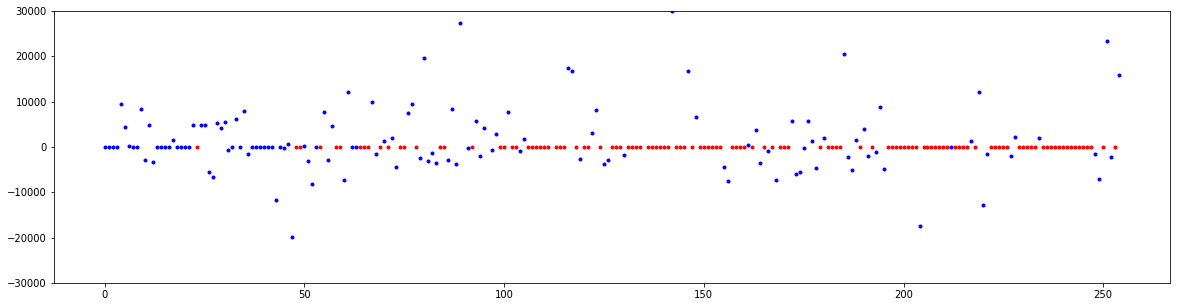

In [39]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge

clf = Lasso(alpha = 50, max_iter = 10000)
clf.fit(Xtrain,ytrain)
print(f"Lasso validation RMSE {metrics.mean_squared_error(yval, clf.predict(Xval), squared = False):.0f}.")
print(f"Počet nenulových koeficientů: {np.sum(np.abs(clf.coef_) > 0)}")

# zkusíme to vizualizovat
ii = np.array(range(len(clf.coef_)), dtype = int)
plt.figure(figsize = (20,5))
# plt.plot(ii, clfLR.coef_, 'gx')
plt.plot(ii[np.abs(clf.coef_) == 0], clf.coef_[np.abs(clf.coef_) == 0], 'r.')
plt.plot(ii[np.abs(clf.coef_) > 0], clf.coef_[np.abs(clf.coef_) > 0], 'b.')
plt.ylim([-30000,30000])
plt.show()

### Výběr příznaků
K výběru z modelu lasso použijeme `SelectFromModel` ze `sklearn`. Zvolíme nějaké větší $\lambda$, abychom vyhodili více příznaků.

Nakonec zkusíme, jak na takto vybrané sadě příznaků bude fungovat model lineární regrese a model rozhodovacího stromu.

In [56]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=Lasso(alpha = 100, max_iter = 10000)).fit(Xtrain, ytrain)
print(f"Vybráno {sum(selector.get_support())} příznaků")
Xtrainsel = Xtrain.loc[:,selector.get_support()]
Xvalsel = Xval.loc[:,selector.get_support()]
Xtestsel = Xtest.loc[:,selector.get_support()]


# Lineární regrese
print("Lineární regrese")
from sklearn.linear_model import LinearRegression
clfLR = LinearRegression()
clfLR.fit(Xtrainsel,ytrain)
print(f"Linear regression validation RMSE {metrics.mean_squared_error(yval, clfLR.predict(Xvalsel), squared = False):.0f}.")

# rozhodovací strom
print("\nRozhodovací strom")
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': range(1, 15)
}

param_comb = ParameterGrid(param_grid)

val_metric = []
for params in param_comb:
    clf = DecisionTreeRegressor(**params, random_state = 42).fit(Xtrainsel, ytrain)
    val_metric.append(metrics.mean_squared_error(yval, clf.predict(Xvalsel), squared = False))
    
best_params = param_comb[np.argmin(val_metric)]
print(f"We found the best params {best_params} with validation RMSE {min(val_metric):.0f}.")

Vybráno 113 příznaků
Lineární regrese
Linear regression validation RMSE 28433.

Rozhodovací strom
We found the best params {'max_depth': 10} with validation RMSE 39981.


### Výsledky
Vidíme, že modelu lineární regrese jsme tímto způsobem pomohli. Modelu rozhodovacího stromu už ne.

### Úkol - zkuste data standardizovat a porovnat modely lasso, hřebenové regrese a lineární regrese s příznaky vybranými pomocí lasso

In [83]:
# Váš kód zde
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Xtrain_sc = scaler.fit_transform(Xtrain)
Xval_sc = scaler.transform(Xval)
Xtest_sc = scaler.transform(Xtest)

# Lasso
clf = Lasso(alpha = 100, max_iter = 10000)
clf.fit(Xtrain_sc,ytrain)
print(f"Lasso validation RMSE {metrics.mean_squared_error(yval, clf.predict(Xval_sc), squared = False):.0f}.")
print(f"Počet nenulových koeficientů: {np.sum(np.abs(clf.coef_) > 0)}")

# Hřebenová regrese
clf = Ridge(alpha = 3)
clf.fit(Xtrain_sc,ytrain)
print(f"Ridge validation RMSE {metrics.mean_squared_error(yval, clf.predict(Xval_sc), squared = False):.0f}.")
print(f"Počet nenulových koeficientů: {np.sum(np.abs(clf.coef_) > 0)}")

# Obyčejná lineární regrese - má numerický problém
clf = LinearRegression()
clf.fit(Xtrain_sc,ytrain)
print(f"Linear regression validation RMSE {metrics.mean_squared_error(yval, clf.predict(Xval_sc), squared = False):.0f}.")
print(f"Počet nenulových koeficientů: {np.sum(np.abs(clf.coef_) > 0)}")

# Výběr příznaků
selector = SelectFromModel(estimator=Lasso(alpha = 900, max_iter = 10000)).fit(Xtrain_sc, ytrain)
print(f"Vybráno {sum(selector.get_support())} příznaků")
Xtrainsel_sc = Xtrain_sc[:,selector.get_support()]
Xvalsel_sc = Xval_sc[:,selector.get_support()]
Xtestsel_sc = Xtest_sc[:,selector.get_support()]
clf = LinearRegression()
clf.fit(Xtrainsel_sc,ytrain)
print(f"Subset linear regression validation RMSE {metrics.mean_squared_error(yval, clf.predict(Xvalsel_sc), squared = False):.0f}.")

Lasso validation RMSE 28072.
Počet nenulových koeficientů: 186
Ridge validation RMSE 28654.
Počet nenulových koeficientů: 249
Linear regression validation RMSE 17756294890427674.
Počet nenulových koeficientů: 254
Vybráno 83 příznaků
Subset linear regression validation RMSE 28069.
